# Import Modules

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from datetime import datetime
from keras.layers import Dense
from keras.models import Sequential
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import chi2
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import r_regression, SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils._testing import ignore_warnings
from tensorflow import keras
from keras.callbacks import TensorBoard
from tabulate import tabulate
from xgboost import XGBClassifier

%matplotlib inline


2022-11-25 08:37:01.120006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.show_dimensions', True)
pd.set_option('display.max_columns', 200)


# Load Data

In [3]:
df = pd.DataFrame()
datasets_folder = '../Datasets/telco churn/'

for file in os.listdir(datasets_folder):
    if file.startswith('~') or file == 'Telco_customer_churn_population.xlsx' or file.endswith('ipynb') or file == 'Output' or file == '.DS_Store':
        # print('Ignoring', file)
        continue
    # print('Starting', file)
    if len(df) == 0:  # create a new dataframe if this is the first file
        df = pd.read_excel(datasets_folder + file)
    else:
        # print(file)
        df_to_merge = pd.read_excel(datasets_folder + file)
        cols_to_use = df_to_merge.columns.difference(
            df.columns).tolist()  # only the different columns
        cols_to_use.append('Customer ID')  # append this for merging
        # print(cols_to_use)
        df = df.merge(df_to_merge[cols_to_use], on='Customer ID')

# Add the populations to this dataframe.
df = df.merge(pd.read_excel(datasets_folder + 'Telco_customer_churn_population.xlsx'),
              left_on='Zip Code', right_on='Zip Code')

In [4]:
# The 'Total Charges' column contains an empty whitespace in one of the cells
# We replace it with a string zero
df['Total Charges'] = df['Total Charges'].replace({' ': 0.0})

# Replace NaN in 'Churn Reason' and 'Churn Category' with 'Customer Not Churned'
df['Churn Reason'].fillna('Customer Not Churned', inplace=True)
df['Churn Category'].fillna('Customer Not Churned', inplace=True)

# Drop 'Monthly Charge' column, it's redundant
df.drop('Monthly Charge', axis=1, inplace=True)


In [5]:
df.head()

,Customer ID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Age,Married,Number of Dependents,Under 30,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Device Protection Plan,Internet Type,Number of Referrals,Offer,Premium Tech Support,Quarter,Referred a Friend,Streaming Music,Tenure in Months,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Unlimited Data,Churn Category,Customer Status,Satisfaction Score,ID,Population
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,37,No,0,No,21,10.47,No,DSL,0,None,No,Q3,No,No,2,0,20.94,0.0,129.09,Yes,Competitor,Churned,1,3,58198
1,2967-MXRAV,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,Yes,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,18.80,18.80,No,0,51,5160,Customer Not Churned,29,Yes,0,Yes,0,43.57,No,None,9,None,No,Q3,Yes,No,1,0,43.57,0.0,62.37,No,Customer Not Churned,Joined,3,3,58198
2,9643-AVVWI,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Female,No,Yes,Yes,3,Yes,No,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Electronic check,80.00,241.30,No,0,76,4264,Customer Not Churned,49,Yes,3,No,22,19.18,No,Fiber Optic,2,None,Yes,Q3,Yes,No,3,0,57.54,0.0,298.84,Yes,Customer Not Churned,Joined,3,3,58198
3,0060-FUALY,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Female,No,Yes,No,59,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,94.75,5597.65,No,0,26,5238,Customer Not Churned,60,Yes,0,No,14,16.39,No,Fiber Optic,4,Offer B,No,Q3,Yes,No,59,0,967.01,0.0,6564.66,Yes,Customer Not Churned,Stayed,3,3,58198
4,9696-RMYBA,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.10,398.55,No,0,22,5225,Customer Not Churned,56,No,0,No,13,12.35,No,Fiber Optic,0,None,No,Q3,No,No,5,0,61.75,0.0,460.30,Yes,Customer Not Churned,Stayed,3,3,58198


# Categorical Encoding

In [6]:
# create a dataframe copy just for feature selection
df_fs = df.copy(deep=True)

# encode the categorical data
cat_cols = [col for col in df_fs.columns if df_fs[col].dtype == 'object']
print(cat_cols)
oe = OrdinalEncoder()
df_fs[cat_cols] = oe.fit_transform(df_fs[cat_cols])

['Customer ID', 'Country', 'State', 'City', 'Lat Long', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Label', 'Churn Reason', 'Married', 'Under 30', 'Device Protection Plan', 'Internet Type', 'Offer', 'Premium Tech Support', 'Quarter', 'Referred a Friend', 'Streaming Music', 'Unlimited Data', 'Churn Category', 'Customer Status']


# Feature Selection

## Drop Useless Features

In [7]:
# columns chosen to ignore
cols_to_drop = ['Count', 'Country', 'State', 'Quarter', 'ID', 'Lat Long', 'Customer ID', 'Churn Label',
                'Churn Category', 'Churn Reason', 'Customer Status', 'Age', 'Dependents']

# x and y
x = df_fs.drop(cols_to_drop + ['Churn Value'], axis=1)
y = df_fs['Churn Value']

In [8]:
# create this empty set to collect only the selected features later
features = set()

## Lasso Model

In [9]:
reg = LassoCV()
reg.fit(x, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(x, y))
coef = pd.Series(reg.coef_, index=x.columns)

Best alpha using built-in LassoCV: 0.282095
Best score using built-in LassoCV: 0.518708


In [10]:
print("Lasso picked " + str(sum(coef != 0)) +
      " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")

Lasso picked 8 variables and eliminated the other 36 variables.


Text(0.5, 1.0, 'Feature importance using Lasso Model')

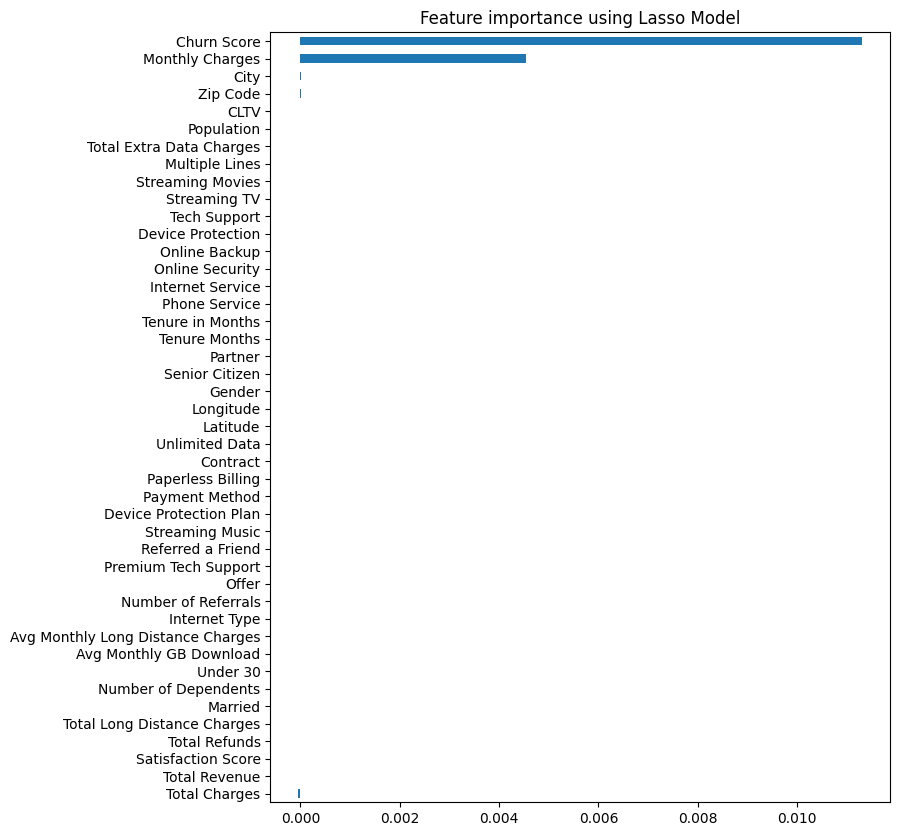

In [11]:
imp_coef = coef.sort_values()
mpl.rcParams['figure.figsize'] = (8, 10)
imp_coef.plot(kind="barh")
plt.title("Feature importance using Lasso Model")


In [12]:
for item in imp_coef[imp_coef != 0].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Total Charges.
Adding Total Revenue.
Adding Population.
Adding CLTV.
Adding Zip Code.
Adding City.
Adding Monthly Charges.
Adding Churn Score.


## Chi-square

In [13]:
# x contains negative values that cannot be used for chi2
# let's normalize x
scalar = MinMaxScaler()
x_chi = scalar.fit_transform(x)
chi_scores = chi2(x_chi, y)

<AxesSubplot:>

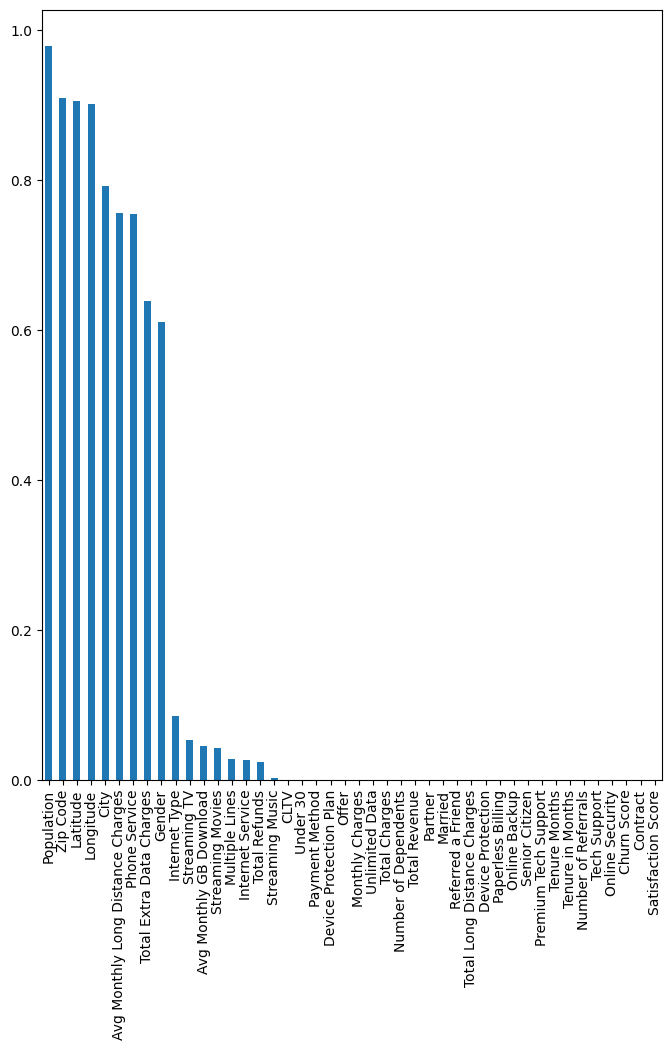

In [14]:
# extract and plot the p-values
p_values = pd.Series(chi_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [15]:
for item in p_values[p_values > 0.2].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Population.
Adding Zip Code.
Adding Latitude.
Adding Longitude.
Adding City.
Adding Avg Monthly Long Distance Charges.
Adding Phone Service.
Adding Total Extra Data Charges.
Adding Gender.


## ANOVA f-value

<AxesSubplot:>

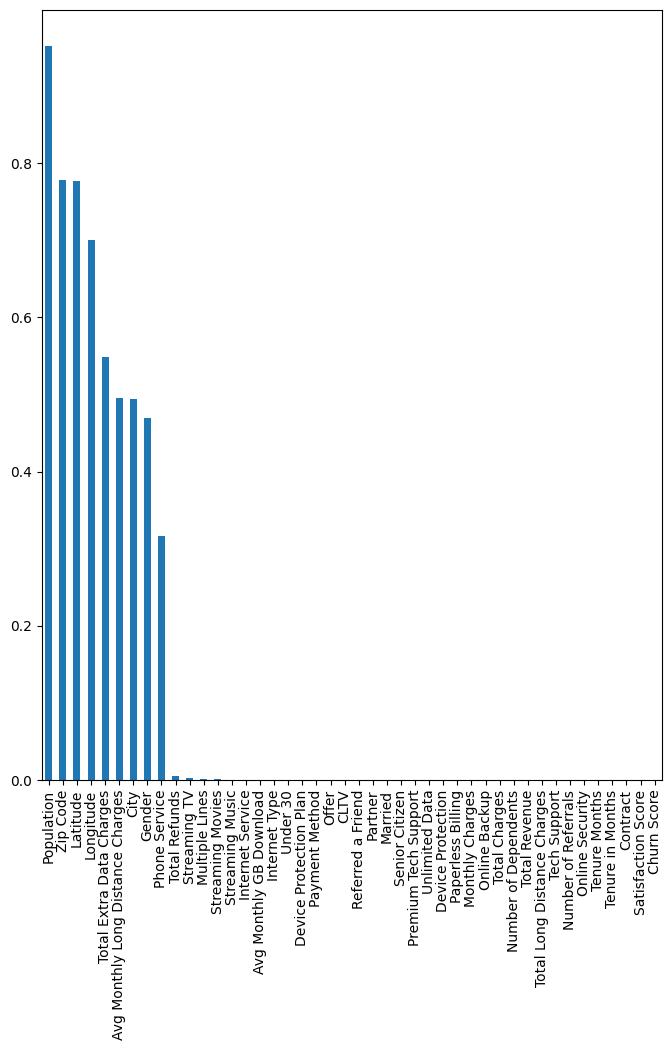

In [16]:
f_scores = f_regression(x, y)
# extract and plot the p-values
p_values = pd.Series(f_scores[1], index=x.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

In [17]:
for item in p_values[p_values > 0.2].index.tolist():
    print(f'Adding {item}.')
    features.add(item)

Adding Population.
Adding Zip Code.
Adding Latitude.
Adding Longitude.
Adding Total Extra Data Charges.
Adding Avg Monthly Long Distance Charges.
Adding City.
Adding Gender.
Adding Phone Service.


## Selected Features

In [18]:
print(f'These are the selected features: {features}.')

These are the selected features: {'Longitude', 'Total Charges', 'Population', 'CLTV', 'Latitude', 'City', 'Monthly Charges', 'Gender', 'Churn Score', 'Total Revenue', 'Avg Monthly Long Distance Charges', 'Total Extra Data Charges', 'Phone Service', 'Zip Code'}.


In [19]:
# categorical encoded columns + selected features only
x = df_fs[list(features)]
y = df_fs['Churn Value']

# Machine Learning

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [21]:
@ignore_warnings(category=ConvergenceWarning)
class ClassifierModels():
    def __init__(self, df, x, y, x_test, y_test):
        '''Init function. Make sure to pass x_train and y_train here.'''

        self.df = df
        self.x = x
        self.y = y
        self.x_test = x_test
        self.y_test = y_test
        
        print('#' * 60)
        print(f'{" Loading dataframe ":#^60}')
        print('#' * 60)
        print(f'{" Getting best parameters to create our models ":#^60}')
        print('#' * 60)

        # hold abbreviations and full names
        self.model_abr = {
            'lr': 'Logistic Regression',
            'knn': 'KNeighbors Classifier',
            'svm': 'Support Vector Machine',
            'dtc': 'Decision Tree Classifier',
            'rfc': 'Random Forest Classifier',
            'ensemble': 'Voting Classifier',
            'xgb': 'XGB Classifier',
            'nb': 'Naive Bayes'
            }

        # hold the actual models
        self.models = {}
        self.model_predicts = {}
        self.model_predicts_proba = {}

        # loop over the models dict to get each model's best params
        for model in self.model_abr:
            print('#' * 60)
            print(f'{" " + self.model_abr[model] + " ":#^60}')
            print('#' * 60)
            params = self.get_best_params(model)

            print('+++++ Best parameters for the {} model: {}'.format(
                self.model_abr[model], params))
            print('+++++ Creating and fitting the {} model using its best parameters...'.format(
                self.model_abr[model]))

            if model == 'lr':
                m = LogisticRegression(
                    solver=params['solver'],
                    penalty=params['penalty'],
                    C=params['C']
                    )
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'knn':
                m = KNeighborsClassifier(
                    n_neighbors=params['n_neighbors'],
                    weights=params['weights'],
                    metric=params['metric']
                    )
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'svm':
                m = SVC(
                    kernel=params['kernel'],
                    C=params['C'],
                    gamma=params['gamma'],
                    probability=True
                    )
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'dtc':
                m = DecisionTreeClassifier(
                    criterion=params['criterion'],
                    splitter=params['splitter'],
                    max_features=params['max_features']
                    )
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'rfc':
                m = RandomForestClassifier(
                    n_estimators=params['n_estimators'],
                    max_features=params['max_features']
                    )
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'ensemble':
                # weights = np.random.random_integers(1, 10, (10, 5)).tolist()
                m = VotingClassifier(
                    estimators=[
                        ('Logistic Regression', self.models['lr']),
                        ('Decission Tree Classifier', self.models['dtc']),
                        ('Random Forrest Classifier', self.models['rfc']),
                        ('KNN', self.models['knn']),
                        ('SVM', self.models['svm'])
                        ],
                    weights=[10, 10, 10, 10, 10],
                    voting='soft')
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'xgb':
                m = XGBClassifier()
                m.fit(self.x, self.y)

                self.models[model] = m

            elif model == 'nb':
                m = GaussianNB()
                m.fit(self.x, self.y)

                self.models[model] = m

        print('#' * 60)
        print(f'{" All models created and fitted successfully! ":#^60}')
        print('#' * 60)

        # loop over the models and get the y_pred
        for model in self.model_abr:
            y_pred = self.models[model].predict(self.x_test)

            self.model_predicts[model] = y_pred

        # loop over the models and get the y_pred_proba
        for model in self.model_abr:
            y_pred_proba = self.models[model].predict_proba(self.x_test)

            self.model_predicts_proba[model] = y_pred_proba

    @ignore_warnings(category=ConvergenceWarning)
    def get_best_params(self, model):
        '''This method returns the best params for hypertuning each model'''

        if model == 'lr':
            # model
            lr_model = LogisticRegression()

            # params
            solver = ['newton-cg', 'lbfgs', 'liblinear']
            penalty = ['l2']
            C = [100, 10, 1.0, 0.1, 0.01]
            lr_params = dict(solver=solver, penalty=penalty, C=C)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=3, n_repeats=2, random_state=1)
            lr_gsearch = GridSearchCV(
                estimator=lr_model,
                param_grid=lr_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            lr_gresult = lr_gsearch.fit(self.x, self.y)

            return lr_gresult.best_params_

        elif model == 'knn':
            # model
            knn_model = KNeighborsClassifier()

            # params
            n_neighbors = range(1, 31, 2)
            weights = ['uniform', 'distance']
            metric = ['euclidean', 'manhattan', 'minkowski']
            knn_params = dict(n_neighbors=n_neighbors,
                              weights=weights, metric=metric)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=3, n_repeats=2, random_state=1)
            knn_gsearch = GridSearchCV(
                estimator=knn_model,
                param_grid=knn_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            knn_gresult = knn_gsearch.fit(self.x, self.y)

            return knn_gresult.best_params_

        elif model == 'svm':
            # model
            svm_model = SVC()

            # params
            kernel = ['poly', 'rbf', 'sigmoid']
            C = [50, 10, 1.0, 0.1, 0.01]
            gamma = ['scale']
            svm_params = dict(kernel=kernel, C=C, gamma=gamma)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=3, n_repeats=2, random_state=1)
            svm_gsearch = GridSearchCV(
                estimator=svm_model,
                param_grid=svm_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            svm_gresult = svm_gsearch.fit(self.x, self.y)

            return svm_gresult.best_params_

        elif model == 'dtc':
            # model
            dtc_model = DecisionTreeClassifier()

            # params
            criterion = ['gini', 'entropy', 'log_loss']
            splitter = ['best', 'random']
            max_features = ['sqrt', 'log2', None]
            dtc_params = dict(criterion=criterion,
                              splitter=splitter, max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=3, n_repeats=2, random_state=1)
            dtc_gsearch = GridSearchCV(
                estimator=dtc_model,
                param_grid=dtc_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            dtc_gresult = dtc_gsearch.fit(self.x, self.y)

            return dtc_gresult.best_params_

        elif model == 'rfc':
            # model
            rfc_model = RandomForestClassifier()

            # params
            n_estimators = [10, 100, 1000]
            max_features = ['sqrt', 'log2']
            rfc_params = dict(n_estimators=n_estimators,
                              max_features=max_features)

            # cross validation
            cv = RepeatedStratifiedKFold(
                n_splits=3, n_repeats=2, random_state=1)
            rfc_gsearch = GridSearchCV(
                estimator=rfc_model,
                param_grid=rfc_params,
                cv=cv,
                scoring='accuracy',
                error_score=0,
                n_jobs=-1)
            rfc_gresult = rfc_gsearch.fit(self.x, self.y)

            return rfc_gresult.best_params_

        elif model == 'ensemble':
            return

        elif model == 'xgb':
            return

        elif model == 'nb':
            return

        else:
            raise NameError(
                'No grid search model available for {}.'.format(model))

    def show_performance(self):
        '''This method prints the accuracy, precision, recall, and f1 score for each model.'''

        headers = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        tbldata = []
        for model in self.models:
            accuracy = metrics.accuracy_score(
                self.y_test, self.model_predicts[model])
            f1score = metrics.f1_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            precision = metrics.precision_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)
            recall = metrics.recall_score(
                self.y_test, self.model_predicts[model], average='weighted', zero_division=0)

            tbldata.append([self.model_abr[model], accuracy,
                           precision, recall, f1score])

        return tabulate(tbldata, headers=headers, tablefmt="pretty")

In [22]:
cm = ClassifierModels(df_fs[list(features)], x_train, y_train, x_test, y_test)

############################################################
#################### Loading dataframe #####################
############################################################
####### Getting best parameters to create our models #######
############################################################
############################################################
################### Logistic Regression ####################
############################################################


/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

+++++ Best parameters for the Logistic Regression model: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
+++++ Creating and fitting the Logistic Regression model using its best parameters...


/Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


############################################################
################## KNeighbors Classifier ###################
############################################################
+++++ Best parameters for the KNeighbors Classifier model: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}
+++++ Creating and fitting the KNeighbors Classifier model using its best parameters...
############################################################
################## Support Vector Machine ##################
############################################################
+++++ Best parameters for the Support Vector Machine model: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
+++++ Creating and fitting the Support Vector Machine model using its best parameters...
############################################################
################# Decision Tree Classifier #################
############################################################
+++++ Best parameters for the Decision Tree

/Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sergani/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


############################################################
###################### XGB Classifier ######################
############################################################
+++++ Best parameters for the XGB Classifier model: None
+++++ Creating and fitting the XGB Classifier model using its best parameters...
############################################################
####################### Naive Bayes ########################
############################################################
+++++ Best parameters for the Naive Bayes model: None
+++++ Creating and fitting the Naive Bayes model using its best parameters...
############################################################
####### All models created and fitted successfully! ########
############################################################


## Model Performance

In [23]:
print('Performance of the different models:\n', cm.show_performance(), sep='')

Performance of the different models:
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|                          |      Accuracy      |     Precision      |       Recall       |      F1 Score      |
+--------------------------+--------------------+--------------------+--------------------+--------------------+
|   Logistic Regression    | 0.9056068133427964 | 0.9044139920155998 | 0.9056068133427964 | 0.9048059891342003 |
|  KNeighbors Classifier   | 0.7338537970191625 | 0.6858671393967563 | 0.7338537970191625 | 0.6774354356442516 |
|  Support Vector Machine  | 0.7345635202271115 | 0.539583565248446  | 0.7345635202271115 | 0.6221548636948121 |
| Decision Tree Classifier | 0.8949609652235628 | 0.8937534522702155 | 0.8949609652235628 | 0.8942158318960591 |
| Random Forest Classifier | 0.9169623846699787 | 0.9158157899886347 | 0.9169623846699787 | 0.9152749484401752 |
|    Voting Classifier     | 0.9070262597586941 | 0.9054359

### ROC

Text(0.5, 1.0, 'ROC Curves for Models')

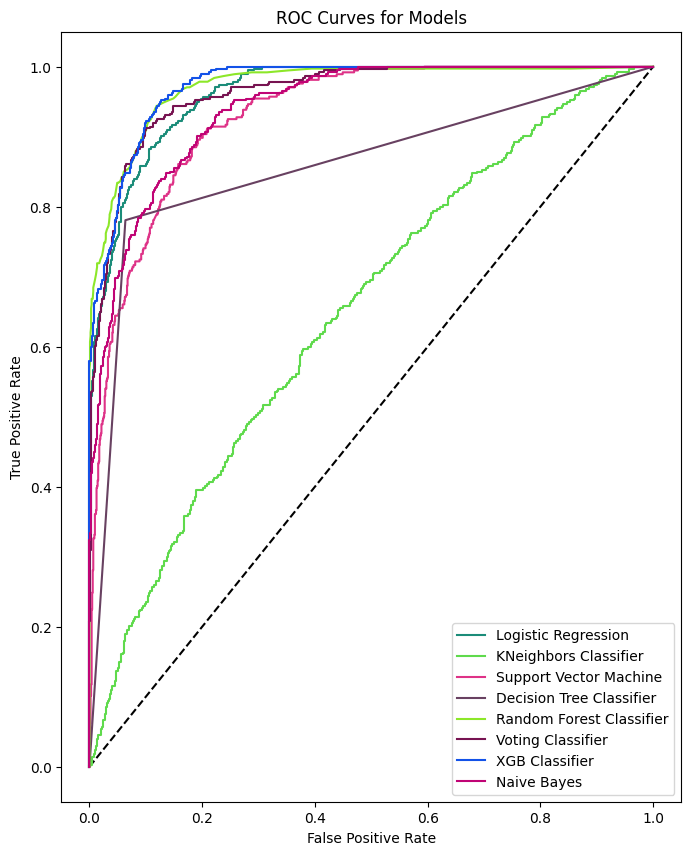

In [24]:
# collect the ROC results
roc_results = {}

for model in cm.model_abr:
    fpr, tpr, thresholds = roc_curve(
        cm.y_test, cm.model_predicts_proba[model][:, 1])

    roc_results[model] = [fpr, tpr, thresholds]

# graph the ROC of all of the models
fig, ax0 = plt.subplots()

ax0.plot([0, 1], [0, 1], 'k--')
for model in roc_results:
    ax0.plot(roc_results[model][0],
             roc_results[model][1], c=np.random.rand(3,), label=cm.model_abr[model])
ax0.set_xlabel('False Positive Rate')
ax0.set_ylabel('True Positive Rate')

ax0.legend()
ax0.set_title('ROC Curves for Models')

### AUC

In [25]:
# table headers and a dictionary to hold the values
headers = ['AUC']
tbl_data_dict = {}

# loop over the classifier models and then their keys abbreviated keys
for k in cm.model_abr:
    auc = roc_auc_score(cm.y_test, cm.model_predicts_proba[k][:, 1])
    tbl_data_dict.setdefault(cm.model_abr[k], []).append(auc)

# create the table data from the dictionary created above
# tabulate doesn't take table data in the form of dictionary created above
tbldata = []
for k, v in tbl_data_dict.items():
    tbldata.append([k] + v)

print(tabulate(tbldata, headers=headers, tablefmt='pretty'))


+--------------------------+--------------------+
|                          |        AUC         |
+--------------------------+--------------------+
|   Logistic Regression    | 0.9633935260533727 |
|  KNeighbors Classifier   | 0.6486476013330233 |
|  Support Vector Machine  | 0.9300718179234804 |
| Decision Tree Classifier | 0.8584902735797876 |
| Random Forest Classifier | 0.9728254411118861 |
|    Voting Classifier     | 0.9634193598387973 |
|      XGB Classifier      | 0.9738897930713787 |
|       Naive Bayes        | 0.9412126378878297 |
+--------------------------+--------------------+


# Deep Learning

In [30]:
%load_ext tensorboard

# create folders
now = datetime.now().strftime('%Y%m%d%H%M')
log_folder = f'Tensorboard Logs/Classification - Telco Churn {now}'

# callbacks for TensorBoard
callbacks = TensorBoard(log_dir=log_folder, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [31]:
x_dl = df_fs.drop('Churn Value', axis=1).values
y_dl = df_fs['Churn Value'].values


In [32]:
# clear previous sessions
keras.backend.clear_session()

# create keras model
model = keras.models.Sequential([
    keras.layers.Dense(6, activation='relu', input_dim=x_dl.shape[1]),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # in case of multiple classification use more perceptrons and softmax
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 348       
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


In [33]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x_dl)

model.compile(optimizer='Adam', loss='BinaryCrossentropy',
              metrics=['AUC', 'Precision', 'Recall'])

# this model shows 'vanishing gradient' behavior; loss doesn't change after a few epochs
model.fit(x=x_scaled, y=y_dl, validation_split=0.3,
          epochs=100, callbacks=callbacks)

Epoch 1/100
155/155 [==============================] - 1s 4ms/step - loss: 0.8510 - auc: 0.6851 - precision: 0.4325 - recall: 0.8643 - val_loss: 0.7870 - val_auc: 0.8479 - val_precision: 0.0339 - val_recall: 0.8824
Epoch 2/100
155/155 [==============================] - 0s 2ms/step - loss: 0.5151 - auc: 0.9668 - precision: 0.6842 - recall: 0.9646 - val_loss: 0.6111 - val_auc: 0.9762 - val_precision: 0.1061 - val_recall: 0.9706
Epoch 3/100
155/155 [==============================] - 0s 2ms/step - loss: 0.3901 - auc: 0.9997 - precision: 0.8839 - recall: 0.9995 - val_loss: 0.5212 - val_auc: 1.0000 - val_precision: 0.3656 - val_recall: 1.0000
Epoch 4/100
155/155 [==============================] - 0s 2ms/step - loss: 0.3261 - auc: 1.0000 - precision: 0.9740 - recall: 1.0000 - val_loss: 0.4605 - val_auc: 1.0000 - val_precision: 0.7391 - val_recall: 1.0000
Epoch 5/100
155/155 [==============================] - 0s 2ms/step - loss: 0.2849 - auc: 1.0000 - precision: 0.9957 - recall: 1.0000 - val_l